In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sbn

sbn.set()

# Exercise 1: Linear Congruential Generator

In [ ]:
def LCG(a = 5, c = 1, M = 16, x0 = 3, n = 10000):
    """ Linear congruential generator for generating psuedo random numbers"""
    x = np.zeros(n)
    x[0] = x0

    for i in range(1, n):
        x[i] = int((a * x[i - 1] + c ) % M)

    return x.astype(int)

def test_chi_square(U):
    """ Compute the p-value of the null-hypothesis that the pseudo-random
        numbers come from a uniform distribution. """
    n = U.shape[0]
    
    k = int(n / 500)

    n_observed = np.histogram(U, bins=k, range=(0,1))[0]
    
    # Compute test statistics
    n_expected = n / k # Choose n_expected >= 5
    Z = ((n_observed - n_expected) ** 2 / n_expected).sum() # test statistic
    
    p = 1 - stats.chi2.cdf(Z, df = k - 1)

    return Z, p # (test statistic, p-value)

def test_ks(U):
    """ Kolmogorov-Smirnov test """
    n = U.shape[0]

    Fxn = U.copy()
    Fxn.sort()

    # Fxn = ECDF(U).x[1:] # Empirical distribution
    
    Fx = np.linspace(0, 1, n) # Hypothesised uniform distribution
    
    Dn = np.abs(Fxn - Fx).max() # Test statistic
    Dn_adjusted = (np.sqrt(n) + .12 + .11 / np.sqrt(n)) * Dn

    # p_value
    p = 1 - stats.kstwobign.cdf(Dn_adjusted)

    # p = stats.kstwo.sf(Dn_adjusted, 1)

    return Dn_adjusted, p

def test_above_below(U):
    Ra = 0
    Rb = 0

    mid = np.median(U)

    n1 = U[U > mid].shape[0]
    n2 = U[U < mid].shape[0]

    mean_ = 2 * n1 * n2 / (n1 +  n2)
    var_ = (2 * n1 * n2) * (2 * n1 * n2 - n1 - n1) / ((n1 + n2) ** 2 * (n1 + n2 - 1))

    diffs = U - mid

    for i in range(0, n):
        # handle first value separately
        if i == 0:
            cur = np.sign(diffs[i])
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 

            continue

        cur = np.sign(diffs[i])
        prev = np.sign(diffs[i - 1])
        if cur != prev:
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 


    Z = Ra + Rb # Test statistic
    p = 1 - stats.norm.cdf(Z, mean_, var_) # p-value

    return Z, p

def test_up_down_knuth(U):
    """ Run test by Knuth """
    n = U.shape[0]
    R = np.zeros(6) # runs

    counter = 0

    for i in range(1, n):
        if U[i] >= U[i-1] or counter == 0: # Should it be GOQ?
            counter += 1
        else:
            if counter > 5:
                R[5] += 1
            else:
                R[counter] += 1
    
    A = np.array([[4529.4, 9044.9, 13568, 18091, 22615, 27892],
                  [9044.9, 18097, 27139, 36187, 45234, 55789],
                  [13568, 27139, 40721, 54281, 67852, 83685],
                  [18091, 36187, 54281, 72414, 90470, 111580],
                  [22615, 45234, 67852, 90470, 113262, 139476],
                  [27892, 55789, 83685, 111580, 139476, 172860]])
    
    B = np.atleast_2d([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840]).T

    R = np.atleast_2d(R).T

    Z = (1/(n - 6) * (R - n*B).T @ A @ (R - n * B))[0, 0]

    p = 1 - stats.chi2.pdf(Z, df = 6)

    return Z, p

def test_up_down_rubenstein(U):
    """ Run test described in Rubenstein 1981 """
    n = U.shape[0]
    
    runs = []

    cur_run = '<' if U[0] <= U[1] else '>'

    counter = 1

    for i in range(1, n - 1):
        if cur_run == '<':
            if U[i] <= U[i + 1]:
                counter += 1
            else:
                cur_run = '>'
                runs.append(counter)
                counter = 1
        else:
            if U[i] >= U[i + 1]:
                counter += 1
            else:
                cur_run = '<'
                runs.append(counter)
                counter = 1

    runs.append(counter)

    X = len(runs)

    Z = (X - (2 *n - 1) / 3) / np.sqrt((16* n - 29) / 90)

    p = stats.norm.cdf(Z)

    return Z, p

def test_correlation(U, h = 1):
    n = U.shape[0]

    sum_ = 0

    for i in range(n - h):
        sum_ += U[i] * U[i + h]

    ch = 1 / (n - h) * sum_

    Z = ch # test statistic

    p = stats.norm.cdf(Z, loc = 0.25, scale = 7 / (144 * n))

    return Z, p

<h3>(a) Generate 10 000 pseudo-random numbers</h3>

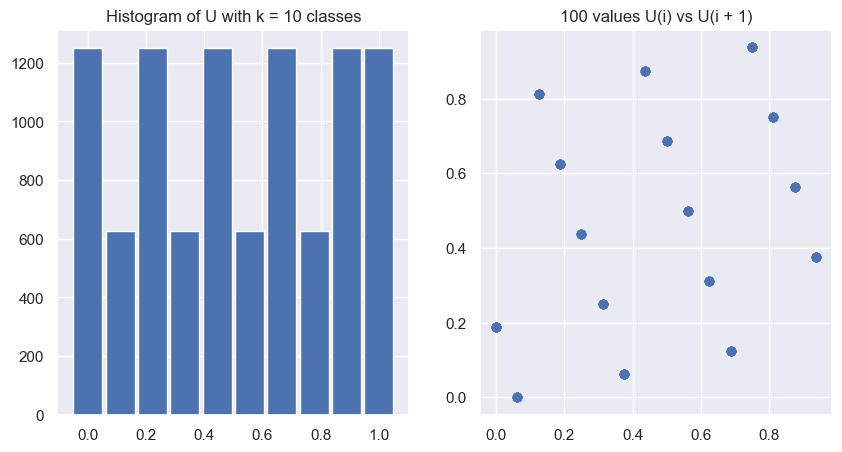

In [ ]:
# Parameter values
n = 10000
x0 = 3
M = 16
a = 5
c = 1

X = LCG(a = a, c = c, M = M, x0 = x0, n = n)
U = X / M

k = 10 # Number of classes

heights = np.histogram(U, bins = k)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(np.linspace(0, 1, k), height = heights, width = .1, )
ax[0].set_title(f'Histogram of U with k = {k} classes')
ax[1].scatter(U[:100][1:], U[:100][:-1])
ax[1].set_title(f'100 values U(i) vs U(i + 1)')
plt.show()

We see from the plots above that the sample of 10000 pseudo random numbers on the surface does not look likely to be uniform and independently distributed. There are high and low peaks in the histogram, and the scatter plot show that there seem to be a pattern between the samples, indicating that the values are highly correlated. Statistical tests can help verify these observations.

<h3>(b) Evaluate quality of generators </h3>

In [ ]:
Z, p = test_chi_square(U)
print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
Z, p = test_ks(U)
print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
Z, p = test_above_below(U)
print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_knuth(U)
print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_rubenstein(U)
print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
Z, p = test_correlation(U)
print(f'Correlation test: test-statistic: {Z}, p-value: {p}')


Chi-square test: test-statistic: 2500.0, p-value: 0.0
Kolmogorov-Smirnov test: test-statistic: 6.25756875, p-value: 0.0
Run test I (Above-Below): test-statistic: 3750, p-value: 0.6914800678415745
Run test II (Up-Down Knuth): test-statistic: 131886190.95337214, p-value: 1.0
Run test III (Up-Down Rubenstein): test-statistic: -9.875106965999812, p-value: 2.668799126482703e-23
Correlation test: test-statistic: 0.24220000125012503, p-value: 0.0


We see from these result that using Chi-square, Kolmogorov-Smirnov and run tests II and III we are able to reject the null hypothesis that the pseudo-random numbers are uniformly distributed using significance level $\alpha = 0.05$.

Using run test I we are not able to make the same conclusion since the p-value is too high.

<h3>(c) Repeat experiment with different parameter values of LCG</h3>

We have already reported bad values of $(a, c, M, x_0) = (5, 1, 16, 3)$ in the previous task. To create a LCG that work well we have experimented with different parameter values and searched the internet for inspiration. We have settled on the following values:

$M = 2^{48} $,
$a = 25214903917$,
$c = 11$,
$x_0 = 3$

We will generate a sample of 10000 pseudo-random numbers using these values and run the same tests as in the previous task

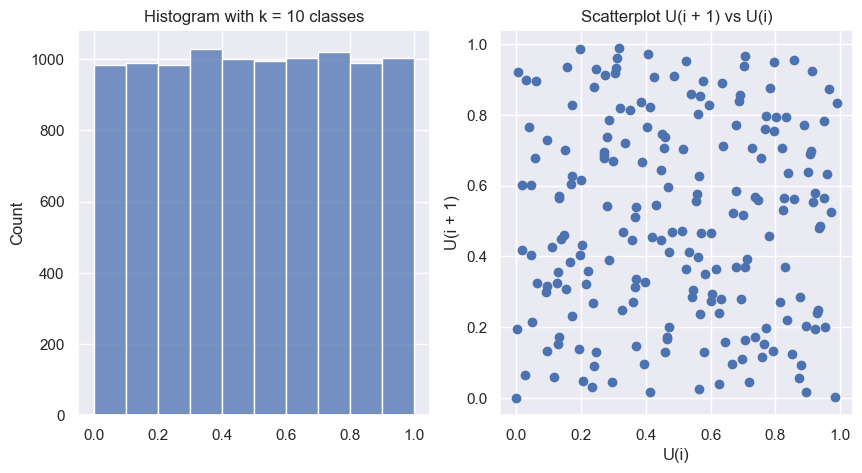

In [ ]:
# a) Generate 10 000 numbers and plot them in histogram
n = 10000
k = 10
M = 2 ** 48
a = 25214903917
c = 11
x0 = 3

# Generating and plotting
nums = LCG(a, c, M, x0, n)
U = nums / M
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()


In [ ]:
Z, p = test_chi_square(U)
print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
Z, p = test_ks(U)
print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
Z, p = test_above_below(U)
print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_knuth(U)
print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_rubenstein(U)
print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
Z, p = test_correlation(U)
print(f'Correlation test: test-statistic: {Z}, p-value: {p}')

Chi-square test: test-statistic: 9.516, p-value: 0.9638928369705171
Kolmogorov-Smirnov test: test-statistic: 0.5817708427811435, p-value: 0.8874606871104923
Run test I (Above-Below): test-statistic: 5023, p-value: 0.49632941571012945
Run test II (Up-Down Knuth): test-statistic: 197837575.10929903, p-value: 1.0
Run test III (Up-Down Rubenstein): test-statistic: 0.6562320882129656, p-value: 0.7441625971725482
Correlation test: test-statistic: 0.25080579837339334, p-value: 1.0


For these parameters of the LCG we get from the plots that they are seemingly uniformly distributed. The vertical bars of the histogram are closely alligned but not exactly the same, indicating that there is some (pseudo) random variation in the frequency of the sample. The plot to the right show no real pattern between one sample and the next in the sequence, meaning that they are not correlated with each other. 

As for the statistical tests, none return a p-value larger than $\alpha = 0.05$, meaning that we accept the null-hypothesis of the sample coming from a uniform distribution.

<h3>(2) Apply a system RNG and perform the same tests</h3>

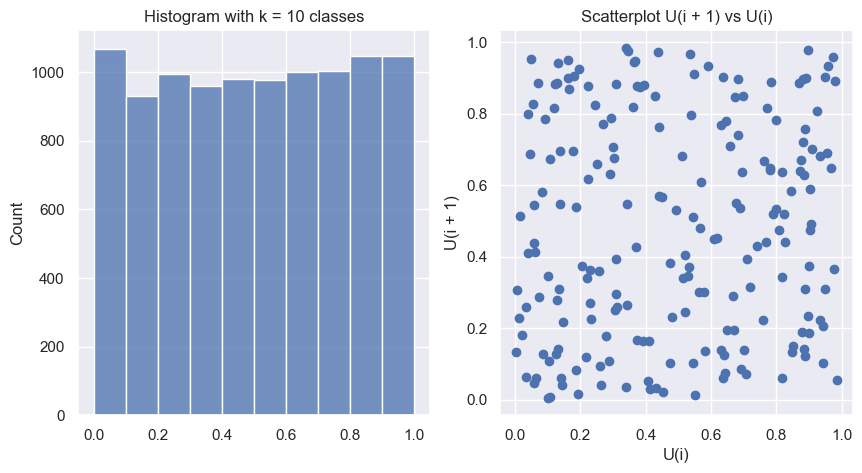

In [ ]:
U = np.random.uniform(0, 1, size = 10000)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()



In [ ]:
Z, p = test_chi_square(U)
print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
Z, p = test_ks(U)
print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
Z, p = test_above_below(U)
print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_knuth(U)
print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_rubenstein(U)
print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
Z, p = test_correlation(U)
print(f'Correlation test: test-statistic: {Z}, p-value: {p}')

Chi-square test: test-statistic: 20.224, p-value: 0.3812140482892272
Kolmogorov-Smirnov test: test-statistic: 1.173409121741645, p-value: 0.12734070083808358
Run test I (Above-Below): test-statistic: 4958, p-value: 0.5067025853136762
Run test II (Up-Down Knuth): test-statistic: 197728613.84687647, p-value: 1.0
Run test III (Up-Down Rubenstein): test-statistic: -1.122710319593247, p-value: 0.13078027187402996
Correlation test: test-statistic: 0.2539737534449725, p-value: 1.0


We get the same results as in the previous task. Here, however the bars of the histogram are less alligned than previously.

<h3>(3) Multiple sample test</h3>

The problem with measuring the performance of our RNG using only one sample is that it is not very fair. We may have gotten lucky with that specific starting value, and ideally our RNG should be able to perform well with any starting value. We can therefore replicate the statistical tests for multiple samples using the LCG with the same parameters except $x_0$ where we expect that the p-values are all sufficient for us to accept the null-hypothesis that the sample is uniformly distributed.

For the sake of brevity we use only the chi-square test for this purpose and the parameters of the LCG as in task (1c), varying only the starting number $x_0$.

# of p-values < 0.05 = 0 for 100 rounds


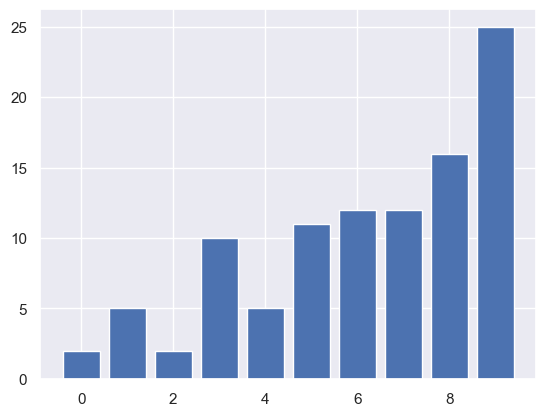

In [ ]:
rounds = 100

x0s = np.random.choice(a = np.arange(0, 1000), replace = False, size=rounds)
p_vals = np.zeros(rounds)

for i, x0 in enumerate(x0s):
    X = LCG(a = a, c = c, M = M, x0 = x0)
    U = X / M
    Z, p = test_chi_square(U)
    p_vals[i] = p

n_bins = 10
hist = np.histogram(p_vals, bins = n_bins)[0]

plt.bar(x = np.arange(0, n_bins, 1), height = hist)

print(f'# of p-values < 0.05 = {(p_vals < 0.05).sum()} for {rounds} rounds')

We see from this that the number of p-values lower than an $\alpha = 0.05$ is zero, meaning that there is statistical significance to accept that the pseudo-random numbers generated using the LCG come from a uniform distribution.

In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sbn
import matplotlib.pyplot as plt
import time
sbn.set()

# Exercise 2

<h3>(1) Generate sample from geometric distribution </h3>

The geometric distribution is created from a uniformly distributed sample and compared to a geometrically distributed sample using a built-in function in python.

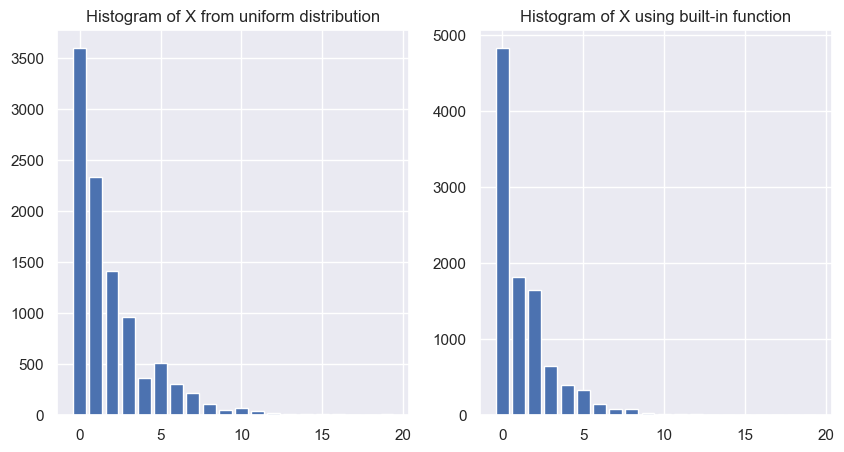

In [ ]:
p = .2
n = 10000

U = np.random.uniform(0, 1, size = n)
X_geom = np.floor(np.log(U) / np.log(1 - p)) + 1
X_geom = X_geom.astype(int)

n_bins = 20

X_geom_true = np.random.geometric(p = p, size = n)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].bar(np.arange(0, n_bins), height = np.histogram(X_geom, bins = n_bins)[0])
ax[0].set_title('Histogram of X from uniform distribution')
ax[1].bar(np.arange(0, n_bins), height = np.histogram(X_geom_true, bins = n_bins)[0])
ax[1].set_title('Histogram of X using built-in function')

plt.show()

The two histograms above are very similar, showing that we have created a geometrically distributed sample from a uniformly distributed sample.

<h3>(2a) Simulate 6-point distribution using crude method </h3>

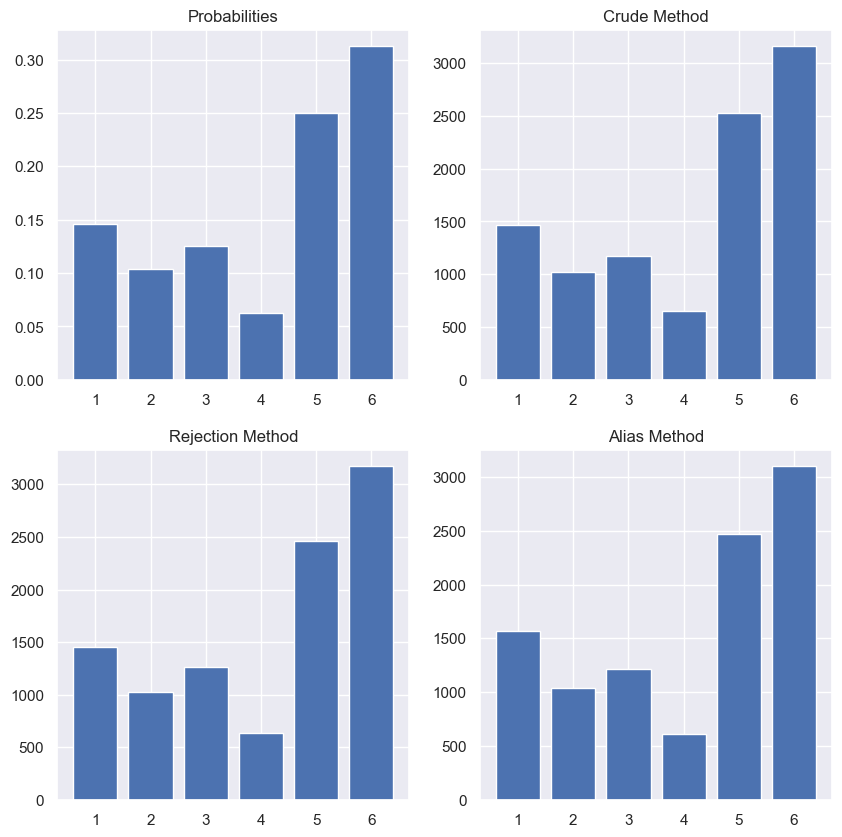

In [ ]:
def crude_method(P, n = 10000):
    U = np.random.uniform(0, 1, size = n)
    probs = np.cumsum(P)
    m = len(probs)

    X = np.zeros_like(U)

    for i, u in enumerate(U):
        for j in range(1, m):
            if probs[j - 1] < u and u <= probs[j]:
                X[i] = j

    return X
    

def rejection_method(P, n = 10000):
    X = np.zeros(n)
    k = len(P)
    c = np.max(P)


    for i in range(n):
        found = False

        while (not found):
        
            temp = np.random.uniform(0, 1, size = 2)
            U1 = temp[0]
            U2 = temp[1]

            I = np.floor(k * U1)
            I = I.astype(int)

            if U2 <= P[I] / c:
                X[i] = I
                found = True

    return X


def alias_method(P, n):

    # Setup
    k = len(P)
    L = np.arange(0, k)
    F = k * P
    G = np.argwhere(F >= 1).flatten().tolist()
    S = np.argwhere(F <= 1).flatten().tolist()

    eps = 0.01

    while len(S) != 0:
        i = G[0] 
        j = S[0]

        L[j] = i

        F[i] = F[i] - (1 - F[j])

        if F[i] < 1 - eps:
            G.remove(i)
            S.append(i)

        S.remove(j)


        # Run
        X = np.zeros(n)
        for i in range(n):
            temp = np.random.uniform(0, 1, size = 2)
            U1 = temp[0]
            U2 = temp[1]

            I = int(np.floor(k * U1))
            I = int(I)

            if U2 <= F[I]:
                X[i] = I
            else:
                X[i] = L[I]

    return X


P = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])

n_bins = len(P)

X1 = crude_method(P, n)
X1_hist = np.histogram(X1, bins = n_bins)[0]

X2 = rejection_method(P, n)
X2_hist = np.histogram(X2, bins = n_bins)[0]

X3 = alias_method(P, n)
X3_hist = np.histogram(X3, bins = n_bins)[0]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].bar(np.arange(1, 7, 1), height=P)
axs[0, 0].set_title('Probabilities')

axs[0, 1].set_title('Crude Method')
axs[0, 1].bar(np.arange(1, 7, 1), height = X1_hist)

axs[1, 0].set_title('Rejection Method')
axs[1, 0].bar(np.arange(1, 7, 1), height=X2_hist)

axs[1, 1].set_title('Alias Method')
axs[1, 1].bar(np.arange(1, 7, 1), height=X3_hist)

plt.show()

The different simulations of the point distributions are shown for 10000 samples. While they are similar there are differences between the histograms.

<h3>(3) and (4) Compare the different discrete random variable simulation methods</h3>

To test the different methods for simulating random variables we use the built in chi square test to see if the histograms of the variables come from a distribution with the given probabilities

In [ ]:
E_freq = P * n # Expected frequencies

discrete_rv_sim = {
    'crude' : X1_hist,
    'rejection' : X2_hist,
    'alias' : X3_hist    
}

for k, v in discrete_rv_sim.items():
    test = stats.chisquare(f_obs = v, f_exp = E_freq)
    Z = test.statistic
    p = test.pvalue

    print(f'Simulation method {k} => (test statistic, pvalue) = {(Z, p)}')



Simulation method crude => (test statistic, pvalue) = (6.456125714285716, 0.2643296110222158)
Simulation method rejection => (test statistic, pvalue) = (1.7172914285714325, 0.8867141729465251)
Simulation method alias => (test statistic, pvalue) = (10.234125714285693, 0.06886677068115828)


Using a threshold $\alpha > 0.05$ we accept the null-hypothesis that these simulated discrete random variables comes from a distribution with the specifed probabilites. The alias method is seemingly the closest to being rejected with a test-statistic that is more extreme than the others. conversely, the rejection method seems to be performing the best. Next is testing the time it takes to simulate discrete random variables with the different methods.

In [ ]:
methods = {'crude' : crude_method, 'rejection' : rejection_method, 'alias' : alias_method}
n_generate = 1000000

for k, method in methods.items():
    start = time.time()    
    X = method(P, n = n_generate)
    stop = time.time()
    t = stop - start 
    print(f'Spent t = {t} seconds simulating {n_generate} random variables using {k} method')


Spent t = 1.0803461074829102 seconds simulating 1000000 random variables using crude method
Spent t = 4.63048791885376 seconds simulating 1000000 random variables using rejection method
Spent t = 11.200064182281494 seconds simulating 1000000 random variables using alias method


We see that the alias method is the slowest, while the crude method is the fastest. All in all the rejection method is the preferred method if wanting to go for accuracy while the crude method is best if speed is preferred

# Exercise 3

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

<h3>(1) Generate simulated values from distributions </h3>

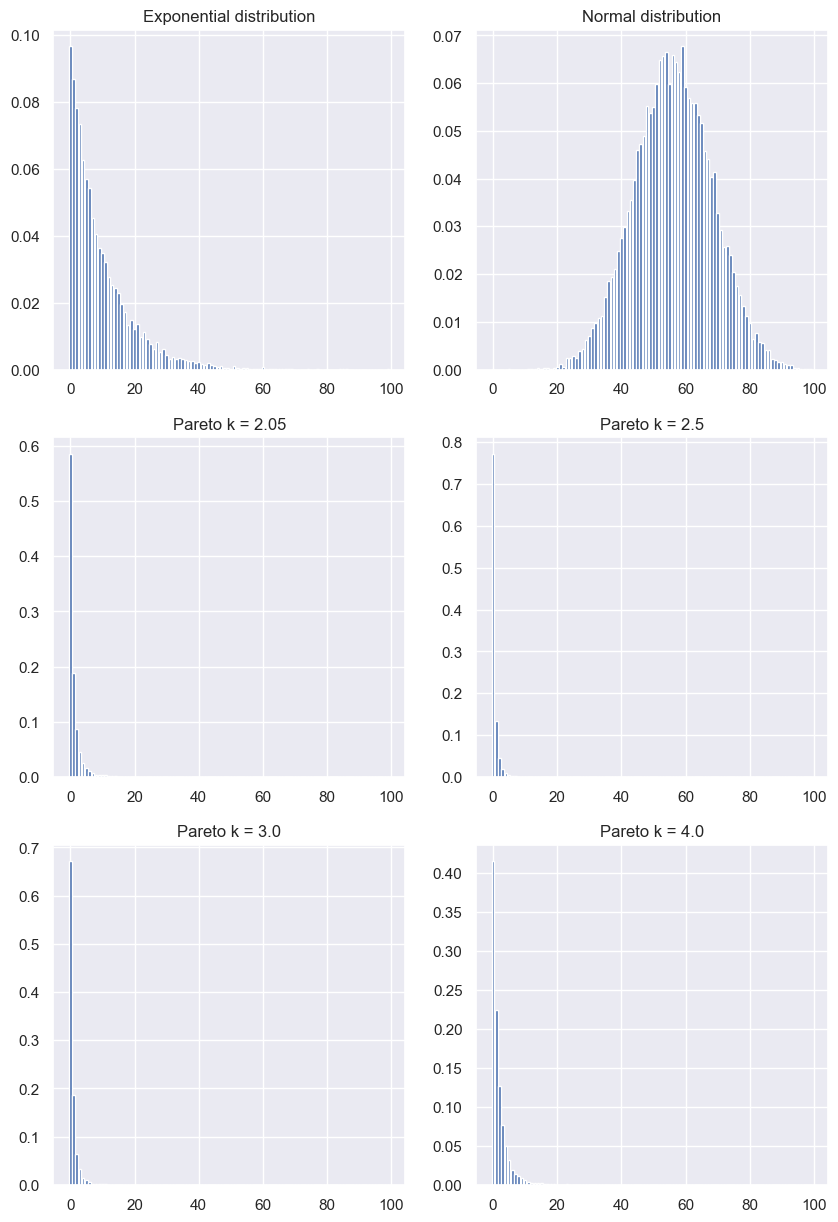

In [ ]:
def exponential_distribution(lambda_, n = 10000):
    U = np.random.uniform(0, 1, size = n)
    X = -np.log(U) / lambda_
    return X

def standard_normal_distribution(n = 10000):
    # Using Box-Muller method
    U1 = np.random.uniform(0, 1, size = n)
    U2 = np.random.uniform(0, 1, size = n)

    Z = np.sqrt( -2 * np.log(U1)) * np.stack([np.cos(2 * np.pi * U2), np.sin(2 * np.pi * U2)], axis = 1).T

    return Z[0], Z[1]

def pareto_distribution(beta, k, n = 10000):
    U = np.random.uniform(0, 1, size = n)
    X = beta * U ** (-1/k)

    return X

n_bins = 100
n = 10000

X_exp = exponential_distribution(lambda_ = 10, n = n)
X_exp_hist = np.histogram(X_exp, bins = n_bins)[0] / n

X_norm = standard_normal_distribution(n = n)
X_norm_hist = np.histogram(X_norm, bins = n_bins)[0] / n

k1 = 2.05
k2 = 2.5
k3 = 3.
k4 = 4.

X_par_1 = pareto_distribution(beta = 1, k = k1, n = n)
X_par_1_hist = np.histogram(X_par_1, bins = n_bins)[0] / n

X_par_2 = pareto_distribution(beta = 1, k = k2, n = n)
X_par_2_hist = np.histogram(X_par_2, bins = n_bins)[0] / n

X_par_3 = pareto_distribution(beta = 1, k = k3, n = n)
X_par_3_hist = np.histogram(X_par_3, bins = n_bins)[0] / n

X_par_4 = pareto_distribution(beta = 1, k = k4, n = n)
X_par_4_hist = np.histogram(X_par_4, bins = n_bins)[0] / n

fig, ax = plt.subplots(3, 2, figsize = (10, 15))
ax[0, 0].set_title(f'Exponential distribution')
ax[0, 0].bar(np.arange(0, n_bins, 1), height = X_exp_hist)
ax[0, 1].set_title(f'Normal distribution')
ax[0, 1].bar(np.arange(0, n_bins, 1), height = X_norm_hist)
ax[1, 0].set_title(f'Pareto k = {k1}')
ax[1, 0].bar(np.arange(0, n_bins, 1), height = X_par_1_hist)
ax[1, 1].set_title(f'Pareto k = {k2}')
ax[1, 1].bar(np.arange(0, n_bins, 1), height = X_par_2_hist)
ax[2, 0].set_title(f'Pareto k = {k3}')
ax[2, 0].bar(np.arange(0, n_bins, 1), height = X_par_3_hist)
ax[2, 1].set_title(f'Pareto k = {k4}')
ax[2, 1].bar(np.arange(0, n_bins, 1), height = X_par_4_hist)

plt.show()


<h3>(2) Pareto distribution moments </h3>

In [ ]:
X1 = pareto_distribution(beta = 1, k = k1, n = n)
X2 = pareto_distribution(beta = 1, k = k2, n = n)
X3 = pareto_distribution(beta = 1, k = k3, n = n)
X4 = pareto_distribution(beta = 1, k = k4, n = n)

ks = [k1, k2, k3, k4]

def pareto_moments_analytical(beta, k):
    Ex = beta * k / (k - 1)
    if k > 2:
        Varx = beta ** 2 * k / ((k - 1) ** 2 * (k - 2))
    else:
        Varx = None

    return Ex, Varx

beta = 1

pareto_simulations = {
    k1 : X1,
    k2 : X2, 
    k3 : X3,
    k4 : X4
}

for k in ks:
    E, Var = pareto_moments_analytical(beta, k)
    mean_x = np.mean(pareto_simulations.get(k))
    var_x = np.var(pareto_simulations.get(k))

    print(f' k = {k}, (mean, var),   Simulation: ({mean_x:.4f}, {var_x:.4f}), Analytical: ({E:.4f}, {Var:.4f}) ')


 k = 2.05, (mean, var),   Simulation: (1.9686, 6.6970), Analytical: (1.9524, 37.1882) 
 k = 2.5, (mean, var),   Simulation: (1.6754, 2.1521), Analytical: (1.6667, 2.2222) 
 k = 3.0, (mean, var),   Simulation: (1.5078, 0.7531), Analytical: (1.5000, 0.7500) 
 k = 4.0, (mean, var),   Simulation: (1.3358, 0.2165), Analytical: (1.3333, 0.2222) 


The second moment (variance) is much harder to capture for the pareto distribution than the first moment. It get's better the larger k-value we use.

<h3> (3) Normal distribution confidence intervals </h3>

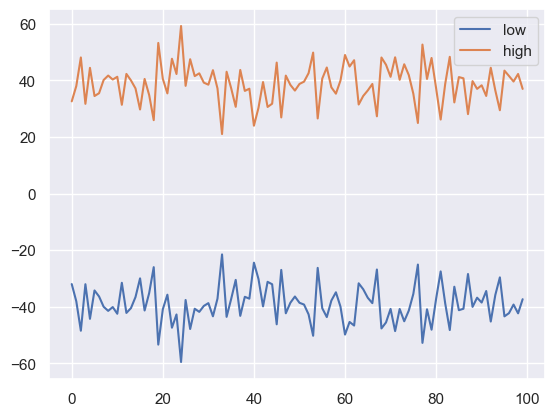

In [ ]:
def confidence_interval(vals, alpha = 0.05):
    if type(vals) != np.ndarray:
        vals = np.array(vals)

    n = len(vals)

    mean_ = np.mean(vals)
    std_error = np.sqrt( 1 / (n - 1) * np.sum((vals - mean_) ** 2))

    t = stats.t.ppf(1 - (alpha / 2), df = n - 1 )

    conf = [mean_ - t * std_error / np.sqrt(n), mean_ + t * std_error / np.sqrt(n)]

    return np.array(conf)

rounds = 100
conf_ints = np.zeros((100, 2))

for r in range(rounds):
    vals = standard_normal_distribution(n = 10)
    conf_ints[r] = confidence_interval(vals, alpha = 0.05)


plt.plot(conf_ints[:, 0], label = 'low')
plt.plot(conf_ints[:, 1], label = 'high')
plt.legend()
plt.show()

<h3>(4) Pareto distribution using composition methods </h3>

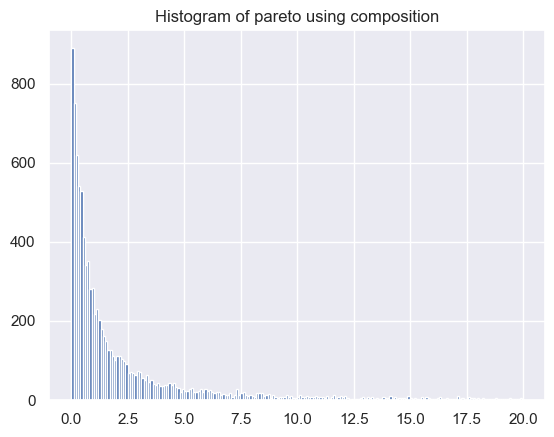

In [ ]:
# Generate Y from f(y)

# Generate X from f(x|y) where Y is used

mu = 1.
f_xs = []
for i in range(10000):
    U = np.random.uniform(0,1, size = 2)
    y = -np.log(U[0])/mu
    f_xs.append(-np.log(U[1])/y)

f_xs = np.array(f_xs)
x = np.arange(0, 20, 1000)
plt.hist(f_xs[f_xs < 20], bins = 200)
plt.title('Histogram of pareto using composition')
plt.show()

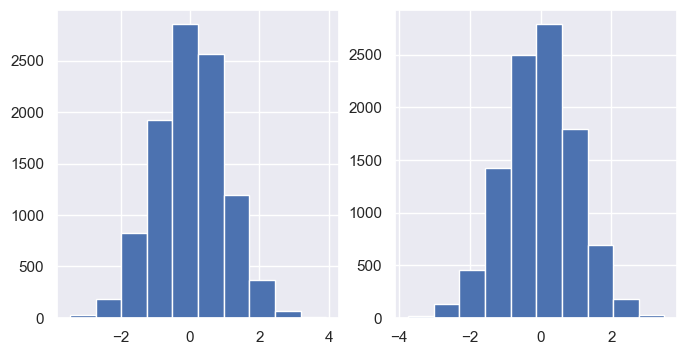

In [ ]:
def standard_normal_distribution(n = 10000):
    # Using Box-Muller method
    U1 = np.random.uniform(0, 1, size = n)
    U2 = np.random.uniform(0, 1, size = n)

    #theta = 2 * np.pi * U2
    #r = np.sqrt( -2 * np.log(U1))

    Z = np.sqrt( -2 * np.log(U1)) * np.stack([np.cos(2 * np.pi * U2), np.sin(2 * np.pi * U2)], axis = 1).T

    return Z[0], Z[1]

Z1, Z2 = standard_normal_distribution(10000)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(Z1)
ax[1].hist(Z2)

plt.show()


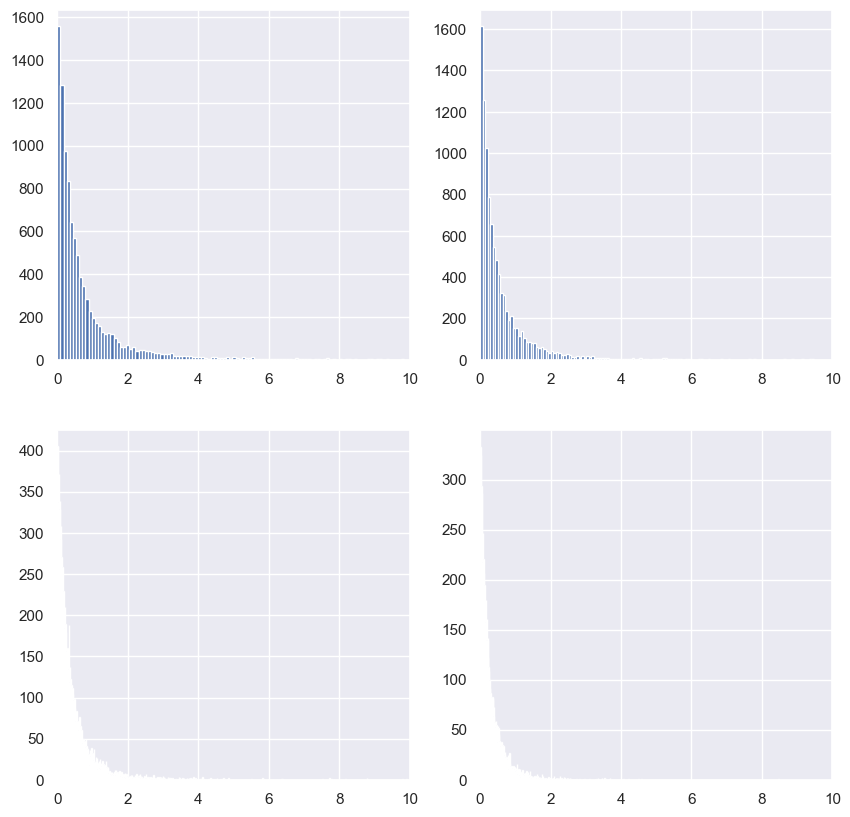

In [ ]:
def pareto_distribution(beta = 1, k = 2.05, n = 10000):
    U = np.random.uniform(0, 1, size = n)

    X = beta * (U ** (-1/k) - 1)

    return X

X1 = pareto_distribution(k = 2.05)
X2 = pareto_distribution(k = 2.5)
X3 = pareto_distribution(k = 3)
X4 = pareto_distribution(k = 4)

Xs = [X1, X2, X3, X4]
n_bins = 100

x_range = np.linspace(0, 1, 10)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axf = ax.flatten()
for i in range(len(axf)):
    axf[i].set_xlim(0, 10)
    axf[i].hist(Xs[i], bins = 1000, color='b')

plt.show()

# Exercise 4

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

<h3>(1) Simulate blocking system</h3>

In [ ]:
def simulate_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10, n = 10000, 
                             arrival_mode = 'poisson', service_mode = 'exponential', service_params = {}):
    """
        Simulate simple blocking system with discrete events and no waiting room.
    """
    t_system = 0
    m = num_servers
    servers = np.zeros(m)
    blocked = 0 # Counter of number of blocked

    for _ in range(n):
        # Sample time from which this customer arrives
        if arrival_mode == 'poisson':
            t_arrival = stats.expon.rvs(scale=arrival_intensity, size = 1)
        elif arrival_mode == 'erlang':
            t_arrival = stats.erlang.rvs(a = 2, scale=arrival_intensity / 2, size = 1)
        elif arrival_mode == 'hyper':
            t_arrival = rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5.0)
        else:
            raise ValueError('Wrong arrival mode specified!')
        
        # Extend system time
        t_system += t_arrival

        # Find available server
        min_server_idx = np.argmin(servers)

        if t_system >= servers[min_server_idx]:
            if service_mode == 'exponential':
                t_service = stats.expon.rvs(scale=mean_service_time, size = 1)
            elif service_mode == 'constant':
                t_service = mean_service_time
            elif service_mode == 'pareto':
                k = service_params.get('k')
                t_service = rvs_pareto(mean_ = mean_service_time, k = k, size = 1)
            elif service_mode == 'normal':
                s = service_params.get('s')
                val = stats.norm.rvs(loc = mean_service_time, scale = s, size = 1)
                if val < 0:
                    val = 0
                t_service = val
            else:
                raise ValueError('Wrong service mode specified')
            servers[min_server_idx] = t_system + t_service
        else:
            blocked += 1

    # Compute blocked fraction
    blocked_fraction = blocked / n

    return blocked_fraction

def rvs_hyperexponential(p = 0.8, lambda_1 = 0.83, lambda_2 = 5.0, size = 1):    
    choices = stats.binom.rvs(p = 1 - p, n = 1, size = size)
    results = np.zeros(size)

    for i, choice in enumerate(choices):
        if choice == 0:
            results[i] =  stats.expon.rvs(scale = 1 / lambda_1, size = 1)    
        else:
            results[i] = stats.expon.rvs(scale = 1 / lambda_2, size = 1)

    return results

def rvs_pareto(mean_ = 8, k = 1.05, size = 1):
    # Find the value of Beta
    beta = mean_ * (k - 1) / k

    # Generate uniform numbers 
    U = np.random.uniform(0, 1, size = size)
    X = beta * (U ** (-1/k))

    return X

def confidence_interval(vals, alpha = 0.05):
    if type(vals) != np.ndarray:
        vals = np.array(vals)

    n = len(vals)

    mean_ = np.mean(vals)
    std_error = np.sqrt( 1 / (n - 1) * np.sum((vals - mean_) ** 2))

    t = stats.t.ppf(1 - (alpha / 2), df = n - 1 )

    conf = [mean_ - t * std_error / np.sqrt(n), mean_ + t * std_error / np.sqrt(n)]

    return np.array(conf)

def analytical_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10):
    lambda_ = arrival_intensity
    s = mean_service_time
    m = num_servers
    A = lambda_ * s

    temp = np.array([A ** i / np.math.factorial(i) for i in np.arange(0, m + 1, 1)])

    B = (A ** m / np.math.factorial(m)) / (temp.sum())

    return B


Compute analytical solution and compare to the confidence interval of the simulated solution

In [ ]:
simulated_fractions = []

for i in range(10):
    blocked_fraction = simulate_blocking_system()
    simulated_fractions.append(blocked_fraction)

conf = confidence_interval(simulated_fractions)

analytical_blocked_fraction = analytical_blocking_system() 

print_conf = conf * 100

print(f'Simulated Blocked fraction confidence interval: [{print_conf[0]:.2f}%, {print_conf[1]:.2f}%]')
print(f'Analytical Blocked fraction: {analytical_blocked_fraction * 100:.2f}%')

Simulated Blocked fraction confidence interval: [11.62%, 12.28%]
Analytical Blocked fraction: 12.17%


The analytical solution is inside the confidence interval of the simulated solution so it seems that the solution is correct

<h3>(2) Experiment with different distributions of arrival time</h3>

In [ ]:
def experiment_arrival_time_distributions():
    arrival_modes = ['poisson', 'erlang', 'hyper']

    print('Blocked fraction values of different arrival modes')
    print('-' * 50)
    for mode in arrival_modes:

        rounds = 10

        block_sims = np.zeros(rounds)

        for r in range(rounds):
            block_sims[r] = simulate_blocking_system(arrival_mode=mode)

        conf_int = confidence_interval(block_sims, alpha = 0.05)
        print_conf_int = conf_int * 100

        print(f'arrival mode: {mode}, conf_int = [{print_conf_int[0]:.2f}%, {print_conf_int[1]:.2f}%]')

experiment_arrival_time_distributions()

Blocked fraction values of different arrival modes
--------------------------------------------------
arrival mode: poisson, conf_int = [11.55%, 12.44%]
arrival mode: erlang, conf_int = [8.88%, 9.74%]
arrival mode: hyper, conf_int = [13.73%, 14.37%]


<h3>(3) Experiment with different service-time distributions</h3>

In [ ]:
def experiment_service_mode_distributions():
    service_modes = ['exponential', 'constant', 'pareto', 'pareto', 'normal']
    service_params = [{}, {}, {'k' : 1.05}, {'k' : 2.05}, {'s' : 2}]

    print('Blocked fraction values of different service modes')
    print('-' * 50)
    for i, mode in enumerate(service_modes):

        rounds = 10

        block_sims = np.zeros(rounds)

        for r in range(rounds):
            block_sims[r] = simulate_blocking_system(service_mode=mode, service_params=service_params[i])

        conf_int = confidence_interval(block_sims, alpha = 0.05)
        print_conf_int = conf_int * 100

        print(f'service mode: {mode}, params: {service_params[i]}, conf_int = [{print_conf_int[0]:.2f}%, {print_conf_int[1]:.2f}%]')

experiment_service_mode_distributions()

Blocked fraction values of different service modes
--------------------------------------------------
service mode: exponential, params: {}, conf_int = [11.62%, 12.50%]
service mode: constant, params: {}, conf_int = [12.03%, 12.70%]
service mode: pareto, params: {'k': 1.05}, conf_int = [0.01%, 0.13%]
service mode: pareto, params: {'k': 2.05}, conf_int = [12.12%, 13.38%]
service mode: normal, params: {'s': 2}, conf_int = [11.45%, 12.27%]


<h3>(4) Compare differences in confidence intervals for prior tasks</h3>

We start by simulating the program with different arrival- and service-time distributions and compare confidence intervals. Every program is simulated 10 times.

In [ ]:
experiment_arrival_time_distributions()
print()
experiment_service_mode_distributions()

Blocked fraction values of different arrival modes
--------------------------------------------------
arrival mode: poisson, conf_int = [11.57%, 12.48%]
arrival mode: erlang, conf_int = [9.05%, 9.67%]
arrival mode: hyper, conf_int = [13.01%, 14.12%]

Blocked fraction values of different service modes
--------------------------------------------------
service mode: exponential, params: {}, conf_int = [11.93%, 12.89%]
service mode: constant, params: {}, conf_int = [11.60%, 12.56%]
service mode: pareto, params: {'k': 1.05}, conf_int = [0.04%, 0.37%]
service mode: pareto, params: {'k': 2.05}, conf_int = [11.65%, 12.12%]
service mode: normal, params: {'s': 2}, conf_int = [11.88%, 12.12%]


The confidence interval for the different arrival time distributions are quite similar, with the hyperexponentiallly distributed arrival times causing slightly larger block fractions than the exponential and erlang. This does make sense as the standard deviation of the arrival times is higher for this distribution, which can lead to congestion in serving the arrivals. The Erlang distribution with $a = 1$ is the same as the exponential distribution, which would make the arrival times identical.

For service modes we get similar results. The block fraction confidence interval is smallest for the constant service time distribution (not counting pareto-distributed service times with k = 1.05), which is to be expected as there is less variability between rounds. Noteably is also that pareto-distributed service times with $k = 1.05$ has the lowest block fraction in general, being almost zero. The mean values of random variables from this distribution is $~2.0$ which is much lower than the mean of the other distributions.

# Exercise 5

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm

sbn.set()

<h3>(1) Crude Monte Carlo estimate </h3>

In [ ]:
n = 10000

actual_integral = np.exp(1) - 1

U = np.random.uniform(0, 1, size = n)

In [ ]:
n = 1000

X = np.exp(U)

X_bar = np.mean(X)

error = np.abs(X_bar - actual_integral) * 100

print(f'Integral estimate Monte Carlo: {X_bar}, actual: {actual_integral}, error = {error:.2f}%')

Integral estimate Monte Carlo: 1.718444477511241, actual: 1.718281828459045, error = 0.02%


<h3>(2) Antithetic estimate </h3>

In [ ]:
X = np.exp(U)

Y = (np.exp(U) + np.exp(1 - U)) / 2

Y_bar = np.mean(Y)

error = np.abs(Y_bar - actual_integral)

print(f'Integral estimate Antithetic: {Y_bar}, actual: {actual_integral}, error = {error * 100:.2f}%')
print(f'Variance reduction = {((np.abs(np.std(Y) ** 2 - np.std(X) ** 2)) / np.std(X) ** 2) * 100:.2f}%')

Integral estimate Antithetic: 1.7191764557701554, actual: 1.718281828459045, error = 0.09%
Variance reduction = 98.40%


The estimate of the integral using antithetic variables is a little bit more precise and reduced the variance with >98 %.

<h3>(3) Control variate estimate</h3>

In [ ]:
X = np.exp(U)

c = np.mean(U * X) - np.mean(U) * np.mean(X)

Z = X + c*(U - 1/2)
Z_bar = np.mean(Z)

error = np.abs(Z_bar - actual_integral)

print(f'Integral estimate Control Variate: {Z_bar:.5f}, actual: {actual_integral:.5f}, error = {error * 100:.2f}%')
print(f'Variance reduction = {((np.abs(np.std(Z) ** 2 - np.std(X) ** 2)) / np.std(X) ** 2) * 100:.2f}%')

Integral estimate Control Variate: 1.71838, actual: 1.71828, error = 0.01%
Variance reduction = 17.31%


<h3>(4) Stratified sampling estimate </h3>

In [ ]:
n_intervals = 10 # Number of intervals
n = U.shape[0]
W = np.zeros(n)

for i in range(n_intervals):
    temp = np.exp(i / n_intervals + U / n_intervals)
    W += temp

W = W / n_intervals

W_bar = np.mean(W)

error = np.abs(W_bar - actual_integral)

print(f'Integral estimate Control Variate: {W_bar:.5f}, actual: {actual_integral:.5f}, error = {error * 100:.2f}%')

Integral estimate Control Variate: 1.71821, actual: 1.71828, error = 0.01%


<h3>(5) Control variate for estimator in simulation </h3>

In [ ]:
def simulate_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10, n = 10000, 
                             arrival_mode = 'poisson', service_mode = 'exponential', service_params = {}, variance_reduction = False):
    """
        Simulate simple blocking system with discrete events and no waiting room.
    """
    t_system = 0
    m = num_servers
    servers = np.zeros(m)
    blocked = 0 # Counter of number of blocked

    U_arrivals = np.random.uniform(0, 1, size = n)
    mu_u = 1/2
    X_arrivals = rvs_poisson(U, lambda_ = 1)

    c = np.cov(X_arrivals, U_arrivals)[0, 1] / np.var(U_arrivals)

    Z = X_arrivals + c * (U_arrivals - mu_u)

    for i in range(n):
        # Sample time from which this customer arrives
        if arrival_mode == 'poisson':
            # t_arrival = stats.expon.rvs(scale=arrival_intensity, size = 1)
            if variance_reduction:
                t_arrival = Z[i]
            else:
                t_arrival = stats.expon.rvs(scale=arrival_intensity, size = 1)
        elif arrival_mode == 'erlang':
            t_arrival = stats.erlang.rvs(a = 1, scale=arrival_intensity, size = 1)
        elif arrival_mode == 'hyper':
            t_arrival = rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5.0)
        else:
            raise ValueError('Wrong arrival mode specified!')
        
        # Extend system time
        t_system += t_arrival

        # Find available server
        min_server_idx = np.argmin(servers)

        if t_system >= servers[min_server_idx]:
            if service_mode == 'exponential':
                t_service = stats.expon.rvs(scale=mean_service_time, size = 1)
            elif service_mode == 'constant':
                t_service = mean_service_time
            elif service_mode == 'pareto':
                k = service_params.get('k')
                t_service = rvs_pareto(mean_ = mean_service_time, k = k, size = 1)
            elif service_mode == 'normal':
                s = service_params.get('s')
                val = stats.norm.rvs(loc = mean_service_time, scale = s, size = 1)
                if val < 0:
                    val = 0
                t_service = val
            else:
                raise ValueError('Wrong service mode specified')
            servers[min_server_idx] = t_system + t_service
        else:
            blocked += 1

    # Compute blocked fraction
    blocked_fraction = blocked / n

    return blocked_fraction

def rvs_hyperexponential(p, lambda_1, lambda_2, u_1, u_2):
    res = np.zeros(len(u_1))
    res[u_2 <= p] = rvs_poisson(lambda_ = lambda_1, U = u_1[u_2 <=p])
    res[u_2 > p] = rvs_poisson(lambda_ = lambda_2, U = u_1[u_2 > p])
    return res

def rvs_poisson(U, lambda_ = 1):
    return -np.log(U) / lambda_


def rvs_pareto(mean_ = 8, k = 1.05, size = 1):
    # Find the value of Beta
    beta = mean_ * (k - 1) / k

    # Generate uniform numbers 
    U = np.random.uniform(0, 1, size = size)
    X = beta * (U ** (-1/k))

    return X

def confidence_interval(vals, alpha = 0.05):
    if type(vals) != np.ndarray:
        vals = np.array(vals)

    n = len(vals)

    mean_ = np.mean(vals)
    std_error = np.sqrt( 1 / (n - 1) * np.sum((vals - mean_) ** 2))

    t = stats.t.ppf(1 - (alpha / 2), df = n - 1 )

    conf = [mean_ - t * std_error / np.sqrt(n), mean_ + t * std_error / np.sqrt(n)]

    return np.array(conf)

def analytical_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10):
    lambda_ = arrival_intensity
    s = mean_service_time
    m = num_servers
    A = lambda_ * s

    temp = np.array([A ** i / np.math.factorial(i) for i in np.arange(0, m + 1, 1)])

    B = (A ** m / np.math.factorial(m)) / (temp.sum())

    return B


In [ ]:
rounds = 10
fractions = np.zeros(rounds)
fractions_reduced = np.zeros(rounds)

print(f'Simulating program with and without variance reduction for {rounds} rounds')

for r in tqdm(range(rounds)):
    fractions[r] = simulate_blocking_system(variance_reduction=False)
    fractions_reduced[r] = simulate_blocking_system(variance_reduction=True)

print(f'variance reduction = {np.abs(np.var(fractions_reduced) - np.var(fractions))/ np.var(fractions)}')

Simulating program with and without variance reduction for 10 rounds


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

variance reduction = 0.7149713640396878


<h3> (6) Common Random numbers </h3>

In [ ]:
def simulate_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10, n = 10000, 
                             arrival_mode = 'poisson', service_mode = 'exponential', service_params = {}, variance_reduction = False, seed = 0):
    """
        Simulate simple blocking system with discrete events and no waiting room.
    """
    t_system = 0
    m = num_servers
    servers = np.zeros(m)
    blocked = 0 # Counter of number of blocked
    np.random.seed(seed)

    U1_arrivals = np.random.uniform(0, 1, size = n)
    U2_arrivals = np.random.uniform(0, 1, size = n)

    if arrival_mode == 'poisson':
        arrival_times = rvs_poisson(U = U1_arrivals)
    elif arrival_mode == 'hyper':
        arrival_times = rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5., u_1 = U1_arrivals, u_2 = U2_arrivals)

    for i in range(n):
        # Sample time from which this customer arrives
        t_arrival = arrival_times[i]
        
        # Extend system time
        t_system += t_arrival

        # Find available server
        min_server_idx = np.argmin(servers)

        if t_system >= servers[min_server_idx]:
            if service_mode == 'exponential':
                t_service = stats.expon.rvs(scale=mean_service_time, size = 1)
            elif service_mode == 'constant':
                t_service = mean_service_time
            elif service_mode == 'pareto':
                k = service_params.get('k')
                t_service = rvs_pareto(mean_ = mean_service_time, k = k, size = 1)
            elif service_mode == 'normal':
                s = service_params.get('s')
                val = stats.norm.rvs(loc = mean_service_time, scale = s, size = 1)
                if val < 0:
                    val = 0
                t_service = val
            else:
                raise ValueError('Wrong service mode specified')
            servers[min_server_idx] = t_system + t_service
        else:
            blocked += 1

    # Compute blocked fraction
    blocked_fraction = blocked / n

    return blocked_fraction

In [ ]:
rounds = 10

blocked_fractions = np.zeros((rounds, 2))

for r in range(rounds):
    blocked_fractions[r] = np.array([simulate_blocking_system(seed = 0, arrival_mode='poisson'), simulate_blocking_system(seed = 0, arrival_mode='hyper')]) 

p_val = stats.ttest_rel(blocked_fractions[:, 0], blocked_fractions[:, 1]).pvalue
print()
print(f'p-value, difference between the runs {p_val}')


p-value, difference between the runs 1.225027533409345e-143


<h3> Exercise 7 </h3>

In [ ]:
n = int(1e5)
a = 4
res = np.random.randn(n) > a

print(f'Estimate of the probability Z > {a} is {np.mean(res)} with {n} samples')

Estimate of the probability Z > 4 is 2e-05 with 100000 samples


In [ ]:
n = int(1e5)
a = 2
res = np.random.randn(n) > a

print(f'Estimate of the probability Z > {a} is {np.mean(res)}  with {n} samples')

Estimate of the probability Z > 2 is 0.02276  with 100000 samples


In [ ]:
# Using importance sampling
def f(x):
    return stats.norm.pdf(x)

def g(x, a):
    return stats.norm.pdf(x, loc = a, scale = 1)

def h(x, a): # indicator function
    return x > a

n = 10000

for a in [2, 4]:
    X = stats.norm.rvs(loc = a, scale = 1, size = n)

    Z = h(X, a) * f(X) / g(X, a)

    true_prob = 1 - stats.norm.cdf(a)

    print(f'Estimate of the probability Z > {a} is {np.mean(Z)}  with {n} samples')
    print(f'true probability is {true_prob}')



Estimate of the probability Z > 2 is 0.02255436062249762  with 10000 samples
true probability is 0.02275013194817921
Estimate of the probability Z > 4 is 3.132127411343129e-05  with 10000 samples
true probability is 3.167124183311998e-05


<h3> Exercise 8 </h3>

In [ ]:
lambda_ = 1.35483
n = 10000

X = stats.expon.rvs(scale = 1/lambda_, size = n)

def f(X):
    n = X.shape[0]
    res = np.zeros(n)
    for i in range(n):
        res[i] = X[i] <= 1 and X[i] >= 0

    return res

def h(X):
    return np.exp(X)

def g(X, lambda_):
    return lambda_ * np.exp(-lambda_ * X)

res = f(X) * h(X) / g(X, lambda_)

mean_ = np.mean(res)

print(f'Estimate: {mean_}')

Estimate: 1.7194322627736764


# exericse 6

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm

sbn.set()

MISSING

- Warmup needed for Metropolis-Hastings in (1)?

<h3>(1) Metropolis Hastings</h3>

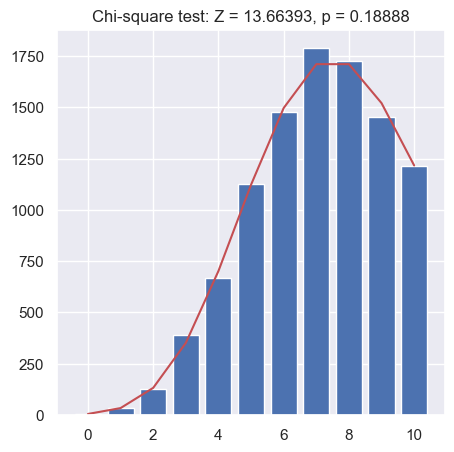

In [ ]:
def analytical_solution(A = 8, m = 10):
    var = [g(A, i) for i in range(m)]
    return var / np.sum(var)

def sample_dxi(m):
    U = np.random.randint(-m, m + 1, size = 1)   
    return U
    
def g(A, i):
    return (A ** i) / np.math.factorial(i)

def metropolis_hastings(A, m = 10, n = 10000):
    # Initialize states
    X = np.zeros(n).astype(int)
    i = 0
    j = 0

    X[0] = i

    for j in range(0, n - 1):
        Xi = X[j]

        dXi = sample_dxi(m)

        Y = int(np.mod(Xi + dXi, m + 1)) # Propose to jump to Yi
        
        gy = g(A = A, i = Y)
        gxi = g(A = A, i = Xi)

        if  gy >= gxi:
            accept = True
        else: 

            U = np.random.uniform(0, 1, 1)
            
            if gy / gxi > U:
                accept = True
            else:
                accept = False

        if accept:
            X[j + 1] = Y
        else:
            X[j + 1] = Xi

    return X

m = 10        
A = 8
n = 10000
X = metropolis_hastings(A = A, m = m, n = n)

X_hist =  np.histogram(X, bins = m + 1, density=0)[0] 

P = analytical_solution(m = m + 1)

test = stats.chisquare(X_hist, P * n)

Z = test.statistic
p = test.pvalue

fig, ax = plt.subplots(1, figsize = (5, 5))
ax.plot(P * n, color = 'r')
ax.bar(x = np.arange(0, m + 1, 1), height = X_hist)
ax.set_title(f'Chi-square test: Z = {Z:.5f}, p = {p:.5f}')

plt.show()

100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]


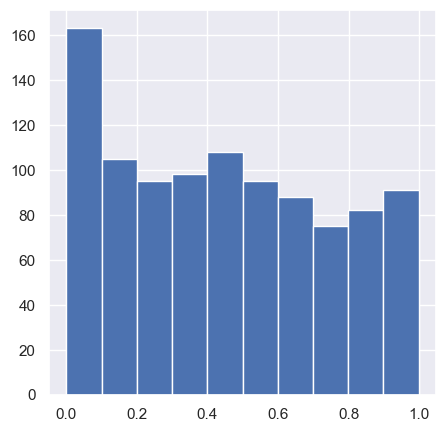

In [ ]:
# Calculate p-values for multiple runs
runs = 1000
p_vals = np.zeros(runs)
step = 4
n = 20000

for r in tqdm(range(runs)):
    X = metropolis_hastings(A = A, m = m, n = n)[::step]

    X_hist =  np.histogram(X, bins = m + 1, density=0)[0] 

    P = analytical_solution(m = m + 1)

    test = stats.chisquare(X_hist, P * (n/step))
    p = test.pvalue

    p_vals[r] = p

p_hist = np.histogram(p_vals, bins = 10)[0]

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.hist(p_vals, bins = 10)

plt.show()

The p-values are somewhat uniformly distributed when we take every fourth value in the simulation. This is likely due to the variables being too dependent on the next value random variate so we can enforce more independence by taking values farther apart. 

<h3>(2) Joint occupied lines </h3>

In [ ]:
def sample_dx(range_, n = 2):
    U = np.random.randint(-range_, range_ + 1, size = n)   
    return U

def g_joined(A1, A2, i, j):
    return ((A1 ** i) / np.math.factorial(i)) * ((A2 ** j) / np.math.factorial(j))

def metropolis_hastings_joined(A = 8, m = 10, N = 10000, mode = 'ordinary'):
    X = np.zeros((N, 2)).astype(int)
    i = 0
    j = 0

    X[0] = [i, j]

    for n in range(0, N - 1):
        Xn = X[n]

        if mode == 'ordinary':

            proposal_found = False
            while not proposal_found:
                dXn = sample_dx(range_ = m, n = 2)

                Y = np.mod(Xn + dXn, m + 1).astype(int) # Propose to jump to Y

                if Y.sum() <= m:
                    proposal_found = True
            
            gy = g_joined(A1 = A[0], A2 = A[1], i = Y[0], j = Y[1])
            gx = g_joined(A1 = A[0], A2 = A[1], i = Xn[0], j = Xn[1])

            if  gy >= gx:
                accept = True
            else: 

                U = np.random.uniform(0, 1, 1)
            
                if gy / gx > U:
                    accept = True
                else:
                    accept = False

            if accept:
                X[n + 1] = Y
            else:
                X[n + 1] = Xn

        elif mode == 'coordinatewise':
            Yk = [Xn]
            
            # First acceptance in x-direction, then y-direction
            for k in range(2):
                
                proposal_found = False

                while not proposal_found:
                    dXnk = sample_dx(range_ = m, n = 1)

                    Y = Yk[k].copy() # Get the current state
                    Y[k] += dXnk # Add the state at the coordinate
                    Y = np.mod(Y, m)

                    if Y.sum() <= m:
                        proposal_found = True

                gy = g_joined(A1 = A[0], A2 = A[1], i = Y[0], j = Y[1])
                gx = g_joined(A1 = A[0], A2 = A[1], i = Xn[0], j = Xn[1])

                if  gy >= gx:
                    accept = True
                else: 
                    U = np.random.uniform(0, 1, 1)
        
                    if gy / gx > U:
                        accept = True
                    else:
                        accept = False

                Yk.append(Y)
            
            X[n] = Y[1]
    return X
    
def analytical_solution_joined(A = [4, 4], m = 10):
    P = np.zeros((m + 1, m + 1))
    A1 = A[0]
    A2 = A[1]

    for i in range(m + 1):
        for j in range(m + 1):
            if (i + j) <= m:
                P[i, j] = ((A1 ** i) / np.math.factorial(i)) * ((A2 ** j) / np.math.factorial(j))


    #var = [g(A, i) for i in range(m)]
    return P / np.sum(P)


X = metropolis_hastings_joined(A = [4, 4], m = 10, N = 10000, mode = 'coordinatewise')
P = analytical_solution_joined(A = [4, 4], m = 10)

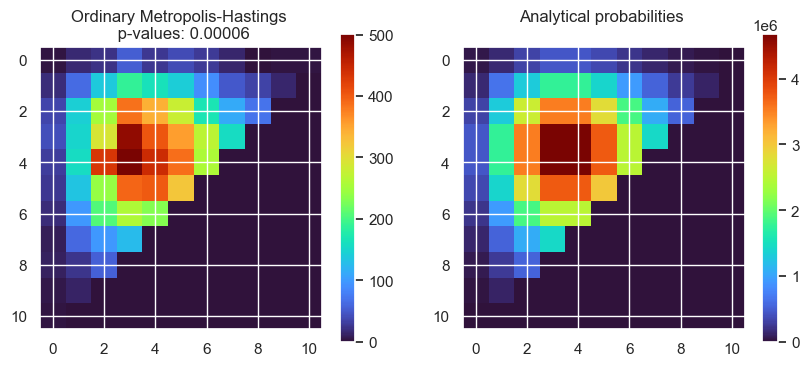

In [ ]:
N = 10000

X = metropolis_hastings_joined(A = [4, 4], m = 10, N = N, mode = 'ordinary')
P = analytical_solution_joined(A = [4, 4], m = 10) * N
X_hist = np.histogram2d(x = X[:, 0], y = X[:, 1], bins = np.arange(0, m + 2, 1), density=False)[0].astype(int)

# Remove zeroes
f_obs = X_hist.flatten()[np.where(X_hist.flatten() > 0)[0]]
f_exp = P.flatten()[np.where(P.flatten() > 0)[0]]

if f_obs.shape < f_exp.shape:
    f_exp = f_exp[:f_obs.shape[0]]
elif f_obs.shape > f_exp.shape:
    f_obs = f_obs[:f_exp.shape[0]]

# Chi square test
test = stats.chisquare(f_obs = f_obs, f_exp = f_exp)

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].set_title(f'Ordinary Metropolis-Hastings \n p-values: {test.pvalue:.5f}')
im1 = ax[0].imshow(X_hist, cmap = 'turbo')
plt.colorbar(im1, ax=ax[0])

ax[1].set_title(f'Analytical probabilities \n')
im2 = ax[1].imshow(P * n, cmap = 'turbo')
plt.colorbar(im2, ax=ax[1])

plt.show()



In [ ]:
# Calculate p-values 
runs = 1000
p_vals = np.ones(runs)
P = analytical_solution_joined(A = [4, 4], m = 10) * N

for r in tqdm(range(runs)):
    X = metropolis_hastings_joined(A = [4, 4], m = 10, N = N, mode = 'ordinary')
    X_hist = np.histogram2d(x = X[:, 0], y = X[:, 1], bins = np.arange(0, m + 2, 1), density=False)[0].astype(int)

    # Remove zeroes
    f_obs = X_hist.flatten()[np.where(X_hist.flatten() > 0)[0]]
    f_exp = P.flatten()[np.where(P.flatten() > 0)[0]]

    if f_obs.shape < f_exp.shape:
        f_exp = f_exp[:f_obs.shape[0]]
    elif f_obs.shape > f_exp.shape:
        f_obs = f_obs[:f_exp.shape[0]]

    # Chi square test
    try: 
        test = stats.chisquare(f_obs = f_obs, f_exp = f_exp)
    except:
        continue
    else:
        p_vals[r] = test.pvalue



100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


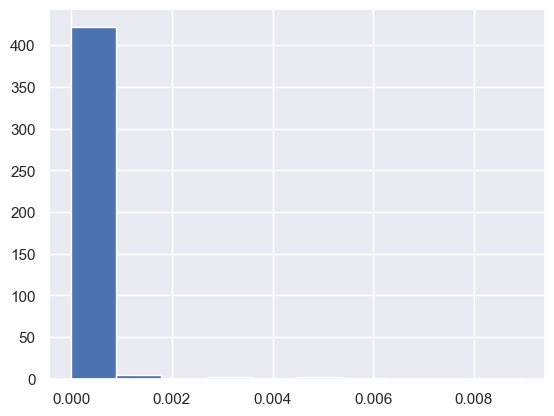

In [ ]:
n_bins = 10
ps = p_vals[p_vals < 1.0]

plt.hist(x = ps, bins = n_bins)
plt.show()

<h3>(3) Bayesian statistical problem </h3>

In [ ]:
# A) 
eta, gamma = np.random.normal(size = 2)

theta = np.exp(eta)
psi = np.exp(gamma)

print(f'Sample (theta, gamma) = ({theta:.3f}, {gamma:.3f})')

Sample (theta, gamma) = (0.594, -0.959)


In [ ]:
# B)
n = 10
X = np.random.normal(loc = theta, scale = psi, size = n)

X

array([0.62220563, 0.65771862, 0.44860369, 0.14776688, 0.93224044,
       0.79442993, 1.00630435, 0.79728159, 0.14652103, 0.57339356])

# Exercise 7

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sbn
import os
sbn.set()

<h3>(1) Simulated Annealing for TSP </h3>

In [ ]:
def permute(route):
    assert type(route) == np.ndarray, 'please insert a route of type ndarray'
    
    route = route.copy()
    # Choose index of two random stations and swap them
    idxs = np.random.choice(np.arange(1, len(route) - 1), size = 2, replace=False)

    temp = route[idxs[0]]
    route[idxs[0]] = route[idxs[1]]
    route[idxs[1]] = temp

    return route

def dist(t_1, t_2):
    return np.sqrt((t_1[0] - t_2[0]) ** 2 + (t_1[1] - t_2[1]) ** 2)

def cost(route, cost_matrix = None, coords = None):
    assert not (cost_matrix is None and coords is None), 'insert either town coordinates or cost matrix'

    if not cost_matrix is None:
        return np.sum([cost_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)])
    else:
        return np.sum([dist(coords[route[i]], coords[route[i + 1]]) for i in range(len(route) - 1)])

def T_1(k):
    return 1 / np.sqrt(1 + k)

def T_2(k):
    return - np.log(k + 1)


def plot_route(route, coords):
    plt.plot(coords[route, 0], coords[route, 1], 'o-')
    plt.show()


def simulated_annealing(n, K, cost_matrix = None, coords = None):

    log_costs = np.zeros(K) # Log costs of states (routes)

    # Generate random route
    route = np.arange(0, n)
    np.random.shuffle(route)
    route = np.append(route, route[0])

    route_original = route.copy()

    # Perform random walk
    for k in range(K):
        # Propose to jump from route to permuted route
        route_perm = permute(route)

        # Calculate cost
        c_1 = cost(route_perm, cost_matrix = cost_matrix, coords = coords)
        c_2 = cost(route, cost_matrix = cost_matrix, coords = coords)
        
        delta_energy = c_1 - c_2

        if delta_energy < 0:
            route = route_perm
        elif np.exp(-delta_energy / T_1(k / 10)) > np.random.uniform(0, 1, 1):
            route = route_perm

        log_costs[k] = cost(route, cost_matrix = cost_matrix, coords = coords)
    
    return route_original, route, log_costs

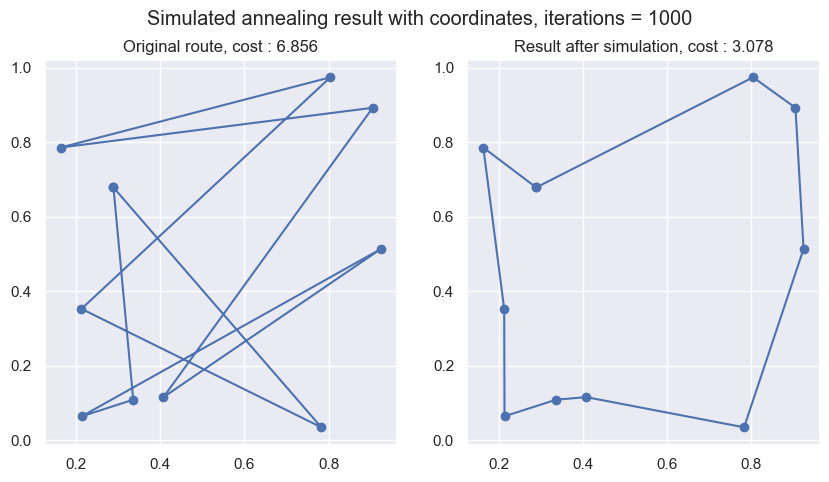

In [ ]:
# Generate random points in plane
n = 10
K = 1000
coords = np.random.rand(n, 2)

route_original, route, _ = simulated_annealing(n, K = K, coords = coords)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(coords[route_original, 0], coords[route_original, 1], 'o-')
ax[0].set_title(f'Original route, cost : {cost(route_original, coords = coords):.3f}')
ax[1].plot(coords[route, 0], coords[route, 1], 'o-')
ax[1].set_title(f'Result after simulation, cost : {cost(route, coords = coords):.3f}')
fig.suptitle(f'Simulated annealing result with coordinates, iterations = {K}')

plt.show()

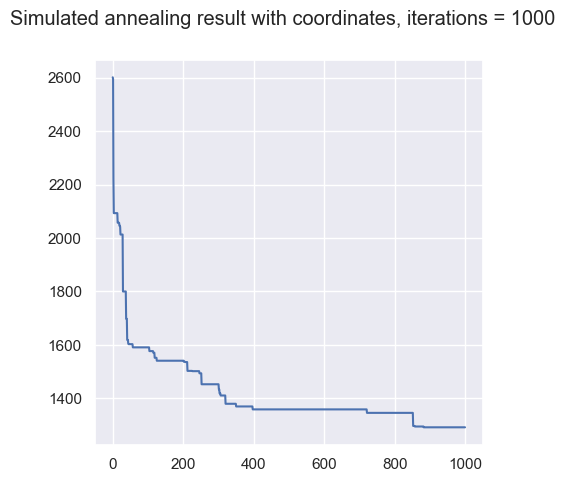

In [ ]:
# Simulated annealing using cost_matrix
cost_matrix = np.loadtxt(os.path.join(os.getcwd(), 'cost.csv'), delimiter=',', dtype=int)
n = 20
K = 1000
route_original, route, log_costs = simulated_annealing(n, K = K, cost_matrix = cost_matrix)

fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(log_costs, label = 'route cost')
fig.suptitle(f'Simulated annealing result with coordinates, iterations = {K}')

plt.show()

# Exercise 8

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sbn

sbn.set()

<h3>Ross exercise 13 </h3>

In [ ]:
X = np.array([56, 101, 78, 67, 93, 87, 64, 72, 80, 69])
n = len(X)
a = -5
b = 5
K = 100000 # bootstrap samples
mu = np.mean(X)
ps = np.zeros(K)

for k in range(K):
    # Sample n values form X
    X_sample = np.random.choice(X, size = n, replace = True)
    
    # count p
    x = np.sum(X_sample) / n

    p = a < (x - mu) and (x - mu) < b
    
    # add estimate of p to list
    ps[k] = p

P = ps.sum() / K

print(f'Probability of p = {P}')

Probability of p = 0.76231


<h3> Ross exercise 15 </h3>

In [ ]:
X = np.array([5, 4, 9, 6, 21, 17, 11, 20, 7, 10, 21, 15, 13, 16, 8])
K = 1000
n = len(X)
sample_vars = np.zeros(K)

for k in range(K):
    # Sample
    X_sample = np.random.choice(X, size = n, replace = True)
    S_2 = np.sum((X_sample - X_sample.mean()) ** 2) / ( n - 1 )
    sample_vars[k] = S_2

print(f'Bootstrap estimate of variance: {np.var(sample_vars):.3f}')

Bootstrap estimate of variance: 59.948


<h3> (3) Bootstrap estimate of median for pareto sample </h3>

In [ ]:
def bootstrap_median(X, R = 100):
    n = len(X)
    median_ = np.median(X)
    sample_medians = np.zeros(R)

    for r in range(R):
        X_sample = np.random.choice(X, size = n, replace = True)
        sample_medians[r] = np.median(X_sample)

    return median_, np.var(sample_medians)


def bootstrap_mean(X, R = 100):
    n = len(X)
    mu = X
    sample_means = np.zeros(n)

    for r in range(R):
        X_sample = np.random.choice(X, size = n, replace = True)
        sample_means[r] = np.mean(X_sample)

    return mu, np.var(sample_means)

N = 200

X = stats.pareto.rvs(1.05, 1, size = N)

# a) mean and median
print(f'Median: {np.median(X)}, mean: {np.mean(X)}')

# b) boostrap variance of mean
_, mean_ = bootstrap_mean(X)
print(f'Bootstrap estimate of variance of mean: {mean_}')

# c) boostrap variance of median
_, median_ = bootstrap_median(X)
print(f'Bootstrap estimate of variance of median: {median_}')



Median: 2.8069947561003827, mean: 8.05961133750623
Bootstrap estimate of variance of mean: 18.74735188717975
Bootstrap estimate of variance of median: 0.015952653700101512


The variance of the median is much lower than the variance of the mean.